In [1]:
# Colab cell
try:
    import google.colab
    IN_COLAB = True
    !wget -q https://raw.githubusercontent.com/Competencia-de-Climate-Change/WeatherBench/master/src/ml_training.py
    !pip install -q -U zarr
    !pip install -q -U fsspec
    !pip install -q -U gcsfs
    !pip install -q -U xarray
except:
    IN_COLAB = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import xarray as xr
import fsspec

ds = xr.open_zarr(fsspec.get_mapper('gcs://weather-bench/region_zarr/'), consolidated=True)
ds = ds.isel(lon=slice(0,12))

print("Tamaño en GB:", ds.nbytes / 1e9)

Tamaño en GB: 16.564237876


# Neural Networks for $T850$ and $T2M$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pickle

from src.ml_training import *

# from dask_ml.wrappers import ParallelPostFit

def to_pickle(obj, fn):
    try:
        with open(fn, 'wb') as f:
            pickle.dump(obj, f)
    except AttributeError:
        obj.to_pickle(fn)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)
    
results = 'results'
verbose = False

import os
if not os.path.exists(results):
    os.makedirs(results)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


## Data Loading

In [5]:
z_500 = ds.z.sel(level=500).drop('level')
t_850 = ds.t.sel(level=850).drop('level')

t2m   = ds.t2m

data = xr.merge([z_500, t_850, t2m])

data_train = data.sel(time=slice('1979', '2000'))
data_test  = data.sel(time=slice('2001', '2005'))

# t_test   = load_test_data('t', ds=ds, years=slice('2001', '2005'))
# t2m_test = load_test_data('t2m', ds=ds, years=slice('2001', '2005'))

# test_data = xr.merge([t_test, t2m_test])

_, nlat, nlon = data_train.z.shape

nlat, nlon

(12, 12)

In [6]:
# Compute normalization statistics
# Let's only take a sample of the time to speed this up.
# data_mean = data.isel(time=slice(0, None, 10000)).mean('time').load()
# data_std  = data.isel(time=slice(0, None, 10000)).std('time').load()

data_max  = data.max().load()
data_min  = data.min().load()

In [7]:
# Normalize datasets
# train_standard = (data_train - data_mean) / data_std
# test_standard  = (data_test - data_mean)  / data_std

train_min_max = (data_train - data_min) / (data_max - data_min)
test_min_max = (data_test - data_min) / (data_max - data_min)

### Define combinations of training data

In [8]:
# Inputs and Outputs
experiments = [
    [['t'],             ['t']],
    [['z', 't'],        ['t']],
    [['z', 't', 't2m'], ['t']],
    [['t2m'],           ['t2m']],
    [['z', 't'],        ['t2m']],
    [['z', 't', 't2m'], ['t2m']],
]

lead_time = 3*24 # Predict 3 days from current time
lead_time_str = '3d'

## Run Experiments

**X and y need to be transposed in order to be of shape = (feaures, number_examples)**

## L - Neural Network

In [9]:
from src.ml_training import compute_weighted_rmse, create_X_y_time, unnormalize_preds
from src.nn_model import *

### Define Model

In [10]:
def L_layer_model(X, Y, layers_dims, hidden_acts, final_act, learning_rate = 0.0075, num_iterations = 3000, X_y_val=None, verbose=False):
    """
    Implements a L-layer neural network: [hidden_acts->RELU]*(L-1)->LINEAR->final_act.
    
    Arguments:
    ----------
    X              (ndarray) : data, numpy array of shape (features, number of examples)
    Y              (ndarray) : true vector, of shape (1, number of examples)
    layers_dims    (iterable): Contains the input size and each layer size, of length (number of layers + 1).
    final_act      (str)     : Final Layer activation func
    hidden_acts    (str)     : Hidden Layers activation func
    learning_rate  (float)   : Learning rate of the gradient descent update rule
    num_iterations (int)     : Number of iterations of the optimization loop
    X_y_val        (iterable): list containing X_val and y_val in order to track cost (optional)
    verbose        (bool)    : Verbose level
    
    Returns:
    --------
    parameters (dictionary)  : Parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    if X_y_val is not None:
        costs_val = []
        cost_val = 0
        early_stop_counter = 0
        max_early_stops = 2
    
    parameters = initialize_parameters_deep(layers_dims, Y)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> hidden_act]*(L-1) -> LINEAR -> final_act.
        AL, caches = L_model_forward(X, parameters, final_act=final_act, hidden_acts=hidden_acts)
        
        # Compute cost.
        cost = mean_squared_error(AL, Y)
    
        # Backward propagation.
        backprop_cost = lambda AL, y : 2 * (AL - y)
        grads = L_model_backward(AL, Y, caches, backprop_cost=backprop_cost, final_act=final_act, hidden_acts=hidden_acts)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if verbose and i % 100 == 0:
            cost_str = "Iteration %i: Training Cost=%f" %(i, cost)
            costs.append(cost)
            if X_y_val is not None:
                AL, _ = L_model_forward(X_y_val[0], parameters, final_act=final_act, hidden_acts=hidden_acts)
                cost_val_prev = cost_val
                cost_val = mean_squared_error(AL, X_y_val[1])
                
                # early stopping
                difference = abs(cost_val_prev - cost_val)
                if difference <= 0.00001:
                    print(f'Validation Cost improved only: {difference}!')
                    early_stop_counter += 1
                    if early_stop_counter >= max_early_stops:
                        print(f'Early stopping triggered.')
                        break
                    
                costs_val.append(cost_val)
                
                cost_str += ", Validation Cost=%f" % (cost_val)
                
            print(cost_str)
               
    # plot the cost
    if X_y_val is None:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    else: # Train and val cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
    return parameters
    

In [11]:
def train_nn(model, data, extra_args, verbose):
    """
    Train a Neural Network model and return the predictions.
    
    Arguments:
    ----------
    model       (func)   : NN model (`L_layer_model` func as example)
    data      (iterable) : Contains X_train, y_train, X_val, y_val, nlat, nlon
    extra_args  (dict)   : Extra arguments to be passed to the model (e.g. learning rate, num iterations)
    verbose     (bool)   : Verbose level
    
    Returns:
    -------
    pred_ds (xr.Dataset) : predictions dataset
    parametes   (dict)   : parameters of fitted model
    mse_train            : mse_train 
    mse_val              : mse_val
    """
    
    X_train, y_train, X_val, y_val, nlat, nlon = data
    
    layers_dims = extra_args['layers_dims']
    layers_dims[0] = X_train.shape[0]
    layers_dims[-1] = y_train.shape[0]
    extra_args['layers_dims'] = layers_dims
    extra_args['X_y_val'] = X_val, y_val
    
    parameters = L_layer_model(X_train, y_train, **extra_args)
    mse_train = mean_squared_error(y_train, predict(X_train, y=None, parameters=parameters))
    mse_val  = mean_squared_error(y_val,   predict(X_val, y=None, parameters=parameters))
    
    
    if verbose:
        print(f'Train MSE = {mse_train}')
        print(f'Test  MSE = {mse_val}')
    
    preds = predict(X_val, y=None, parameters=parameters).T.reshape((-1, nlat, nlon))
    return preds, parameters, mse_train, mse_val


### Model Parameters

In [12]:
preds  = {
    'nn_1': [],
}

models = {
    'nn_1': [],
}

train_mse = {
    'nn_1': [],
}

test_mse = {
    'nn_1': [],
}

weighted_mse = {
    'nn_1': [],
}



model_args = [
    [
        L_layer_model,       
        'nn_1', 
        {
            'layers_dims' : [None, 128, 64, 32, None],
            'hidden_acts' : 'relu',
            'final_act' : 'relu',
            'learning_rate' : 0.03, # default .0075
            'num_iterations' : 1000,  # default / 2 to speed up
            'verbose' : True
        }
    ], 
]

### Training NN

Running: nn_1
0: Input variables = ['t']; output variables = ['t']
Iteration 0: Training Cost=0.278757, Validation Cost=8.502282
Iteration 100: Training Cost=0.268928, Validation Cost=0.270756
Iteration 200: Training Cost=0.268986, Validation Cost=0.270823
Iteration 300: Training Cost=0.268966, Validation Cost=0.270807
Validation Cost improved only: 2.240554909382908e-07!
Iteration 400: Training Cost=0.268966, Validation Cost=0.270807
Validation Cost improved only: 9.322094473573905e-07!
Early stopping triggered.


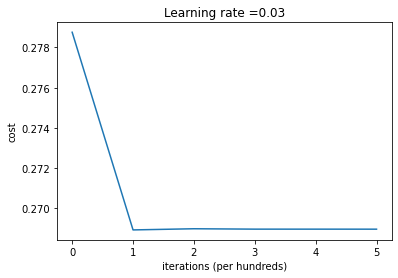

Train MSE = 0.2689594069759649
Test  MSE = 0.27080562330093394
t = 41.738083470903554

1: Input variables = ['z', 't']; output variables = ['t']
Iteration 0: Training Cost=0.283069, Validation Cost=20.239829
Iteration 100: Training Cost=0.365127, Validation Cost=0.367622
Validation Cost improved only: 0.0!
Iteration 200: Training Cost=0.365127, Validation Cost=0.367622
Validation Cost improved only: 0.0!
Early stopping triggered.


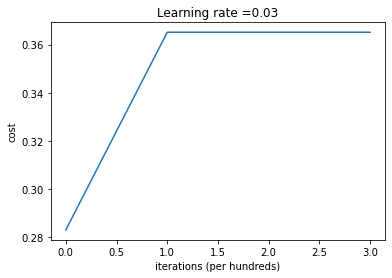

Train MSE = 0.3651268120863165
Test  MSE = 0.3676220571205884
t = 48.36457123589316

2: Input variables = ['z', 't', 't2m']; output variables = ['t']
Iteration 0: Training Cost=0.296881, Validation Cost=26.554208
Iteration 100: Training Cost=0.365127, Validation Cost=0.367622
Validation Cost improved only: 0.0!
Iteration 200: Training Cost=0.365127, Validation Cost=0.367622
Validation Cost improved only: 0.0!
Early stopping triggered.


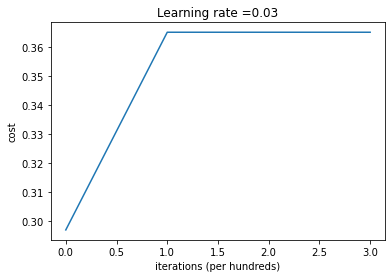

Train MSE = 0.3651268120863165
Test  MSE = 0.3676220571205884
t = 48.36457123589316

3: Input variables = ['t2m']; output variables = ['t2m']
Iteration 0: Training Cost=0.281923, Validation Cost=8.510066
Iteration 100: Training Cost=0.249459, Validation Cost=0.249912
Validation Cost improved only: 6.432425312619117e-06!
Iteration 200: Training Cost=0.249453, Validation Cost=0.249906
Validation Cost improved only: 4.865570834705624e-06!
Early stopping triggered.


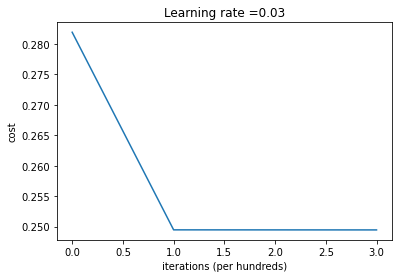

Train MSE = 0.24944785996839394
Test  MSE = 0.24990065319566554
t2m = 47.30640992934008

4: Input variables = ['z', 't']; output variables = ['t2m']
Iteration 0: Training Cost=0.283878, Validation Cost=22.850306
Iteration 100: Training Cost=0.367536, Validation Cost=0.368282
Validation Cost improved only: 0.0!
Iteration 200: Training Cost=0.367536, Validation Cost=0.368282
Validation Cost improved only: 0.0!
Early stopping triggered.


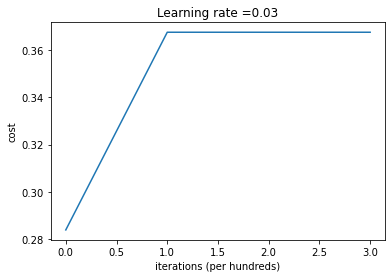

Train MSE = 0.3675361061059901
Test  MSE = 0.36828171596538045
t2m = 57.93561816462986

5: Input variables = ['z', 't', 't2m']; output variables = ['t2m']
Iteration 0: Training Cost=0.298819, Validation Cost=26.816518
Iteration 100: Training Cost=0.367536, Validation Cost=0.368282
Validation Cost improved only: 0.0!
Iteration 200: Training Cost=0.367536, Validation Cost=0.368282
Validation Cost improved only: 0.0!
Early stopping triggered.


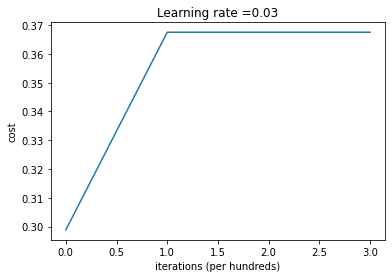

Train MSE = 0.3675361061059901
Test  MSE = 0.36828171596538045
t2m = 57.93561816462986

----------------------------------------------------------------------------


In [13]:
for model_arg in model_args:
    model_fun, model_str, extra_args = model_arg
    
    print('Running:', model_str)
    for idx, (i, o) in enumerate(experiments):
        print(f'{idx}: Input variables = {i}; output variables = {o}')
        X_train, y_train, X_test, y_test, time = create_X_y_time(input_vars=i, 
                                                             output_vars=o, 
                                                             data=[train_min_max, test_min_max], 
                                                             lead_time=lead_time, 
                                                             data_subsample=5)

        data_needed_train = [X_train.T, y_train.T, X_test.T, y_test.T, nlat, nlon]

        predictions, model_res, mse_train, mse_test = train_nn(model=model_fun,
                                                               data=data_needed_train,
                                                               extra_args=extra_args,
                                                               verbose=True)

        predictions = unnormalize_preds(preds=predictions, 
                                        output_vars=o, 
                                        valid_time=time, 
                                        lat_lon=[data_train.lat, data_train.lon],
                                        data_min=data_min,
                                        data_max=data_max)

        preds[model_str].append(predictions)
        models[model_str].append(model_res)

        # Compute Weighted RMSE: RMSE with a weight that takes into account grid location
        r = compute_weighted_rmse(predictions, data).compute()
        if True:
            print('; '.join([f'{v} = {r[v].values}' for v in r]) + '\n')

        train_mse[model_str].append(mse_train)
        test_mse[model_str].append(mse_test)
        weighted_mse[model_str].append(r)

        # Save models
        preds_nc_str  = f'{results}/{model_str}_{lead_time_str}_{"_".join(i)}_{"_".join(o)}.nc'
        model_res_str = f'{results}/{model_str}_{lead_time_str}_{"_".join(i)}_{"_".join(o)}.pkl'

        predictions.to_netcdf(preds_nc_str)
        to_pickle(model_res, model_res_str)
print('----------------------------------------------------------------------------')

In [23]:
import pandas as pd

results_df = pd.DataFrame(columns=['model', 'input', 'output',  'train_mse', 'test_mse', 'weighted_mse'])

block_rows = []
for key in models.keys():
    print(key)
    # repeat key as many time as needed to have a long df
    first_three_cols = np.hstack((np.array([key] * len(experiments)).reshape(len(experiments),1), 
                                  np.array(experiments, dtype='object')))
    block_rows.append(first_three_cols)
    
block_rows = np.array(block_rows).reshape(len(models.keys()) * len(experiments), 3) 

results_df['model'] = block_rows[:, 0]
results_df['input'] = block_rows[:, 1]
results_df['output'] = block_rows[:, 2]


train_mse_col = []
for model, ds_list in train_mse.items():
    train_mse_col += ds_list

test_mse_col = []
for model, ds_list in test_mse.items():
    test_mse_col += ds_list
    

weighted_mse_col = []
for model, ds_list in weighted_mse.items():
    print(model)
    model_metrics = []
    for ds in ds_list:
        exp_metrics = []
        for var in list(ds.variables):
            exp_metrics.append(round(float(ds[var].values), 4))

        model_metrics.append(exp_metrics)
    weighted_mse_col += model_metrics

    
print('\nNumber of rows equals number of metrics? ', results_df.shape[0] == len(train_mse_col))
print(results_df.shape[0], len(train_mse_col))


results_df['train_mse'] = train_mse_col
results_df['test_mse'] = test_mse_col

results_df['weighted_mse'] = weighted_mse_col
results_df['weighted_mse'] = results_df['weighted_mse'].apply(lambda x : x[0])

results_df['output'] = results_df['output'].apply(lambda x: x[0])

results_df.to_csv('results_nn.csv')

results_df

nn_1
nn_1

Number of rows equals number of metrics?  True
6 6


,model,input,output,train_mse,test_mse,weighted_mse
0,nn_1,[t],t,0.268959,0.270806,41.7381
1,nn_1,"[z, t]",t,0.365127,0.367622,48.3646
2,nn_1,"[z, t, t2m]",t,0.365127,0.367622,48.3646
3,nn_1,[t2m],t2m,0.249448,0.249901,47.3064
4,nn_1,"[z, t]",t2m,0.367536,0.368282,57.9356
5,nn_1,"[z, t, t2m]",t2m,0.367536,0.368282,57.9356


In [24]:
import seaborn as sns
sns.set_style('darkgrid')

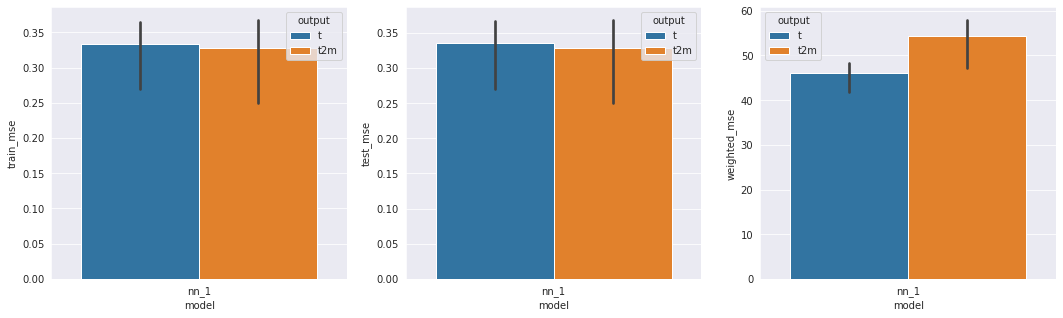

In [25]:
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.barplot(data=results_df, x='model', y='train_mse', hue='output', ax=axs[0])
sns.barplot(data=results_df, x='model', y='test_mse',  hue='output',ax=axs[1])
sns.barplot(data=results_df, x='model', y='weighted_mse', hue='output', ax=axs[2])

plt.savefig('results/nn_mse.png')
plt.show()

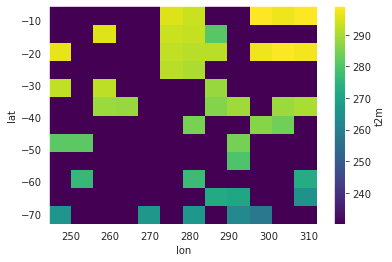

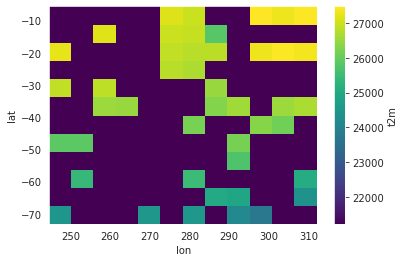

In [26]:
best_pred_t2m = xr.open_dataset('results/nn_1_3d_t2m_t2m.nc')
best_pred_t2m.t2m.mean('time').plot()
plt.show()

(best_pred_t2m * (data_max - data_min)['t2m'] +  data_min['t2m']).mean('time').t2m.plot()
f.savefig('results/nn_1_3d_t2m_t2m__difference.png')
plt.show()

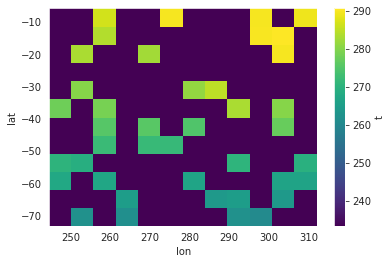

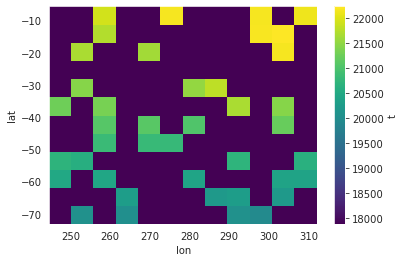

In [27]:
best_pred_t = xr.open_dataset('results/nn_1_3d_t_t.nc')
best_pred_t.t.mean('time').plot()
plt.show()

(best_pred_t * (data_max - data_min)['t'] +  data_min['t']).mean('time')['t'].plot()
f.savefig('results/nn_1_3d_t_t__difference.png')
plt.show()